# **Proyek Akhir Dicoding: Image Classification Model Deployment**

*   Nama : Ayu Kirana Vijayanti Indarto
*   Email: ayukiranav136@gmail.com
*   Dicoding ID: ayukv136
* Linkedin: https://www.linkedin.com/in/ayukiranav136

Pada proyek ini akan mengembangkan model ML untuk klasifikasi gambar kemudian mengkonversi model tersebut ke dalam format berkas TF-Lite yang dapat di embed di Android dan iOS.

## Install kaggle

In [1]:
# install package dengan pip dan upload file json
!pip install -q kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [2]:
# membuat directory
!chmod 600 /content/kaggle.json

In [3]:
# unduh dataset
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d mahmoudreda55/satellite-image-classification

satellite-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


## Mengekstrak dataset

In [4]:
# unzip dataset
import os, zipfile, shutil, PIL
local_zip = '/content/satellite-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Melihat isi dari direktori

In [5]:
base_dir = '/content/data'
label = os.listdir(base_dir)

item_and_label = {}

for a in label:
  item = os.listdir(os.path.join(base_dir, a))
  item_and_label[a] = len(item)

item_and_label

{'cloudy': 1500, 'desert': 1131, 'water': 1500, 'green_area': 1500}

Terdapat 4 class pada dataset yaitu
* Cloudy dengan 1500 gambar
* Desert dengan 1131 gambar
* Water dengan 1500 gambar
* Green Area dengan 1500 gambar

## Import library

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import pathlib

## Preprocessing data dengan image augmentation

Mempersiapkan data dan augmentasi gambar menggunakan Image Data Generator serta memisahkan data menjadi data latih dan data validasi.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

In [8]:
# menentukan nilai target_size dan batch_size
target_size = (150, 150)
batch_size = 32

In [9]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


Pembagian data latih sebesar 80% dan data validasi sebesar 20%, diperoleh:
* Data Latih memiliki 4505 sampel gambar dengan 4 kelas, dan
* Data validasi memiliki 1126 sampel gambar dengan 4 kelas.

## Membangun model Sequential

In [10]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(label), activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

Melakukan compile model

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

## Menginisialisasi fungsi `Callback`

In [13]:
# Penggunaan Callback mencegah overfitting dan menghentikan training setelah akurasi terpenuhi
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.87 and logs.get('val_accuracy') >= 0.87:
      print("\nAkurasi di atas 87%, hentikan training!")
      self.model.stop_training = True

# Utilize callback function
callbacks = myCallback()

## Melatih model dengan `model.fit()`

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch = 4,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 4,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
4/4 - 16s - loss: 1.2527 - accuracy: 0.3984 - val_loss: 1.2041 - val_accuracy: 0.2969 - 16s/epoch - 4s/step
Epoch 2/100
4/4 - 14s - loss: 0.9125 - accuracy: 0.6033 - val_loss: 0.7183 - val_accuracy: 0.6172 - 14s/epoch - 3s/step
Epoch 3/100
4/4 - 14s - loss: 0.5321 - accuracy: 0.7188 - val_loss: 0.7418 - val_accuracy: 0.6016 - 14s/epoch - 4s/step
Epoch 4/100
4/4 - 13s - loss: 0.7169 - accuracy: 0.6875 - val_loss: 0.8564 - val_accuracy: 0.6875 - 13s/epoch - 3s/step
Epoch 5/100
4/4 - 14s - loss: 1.0884 - accuracy: 0.5469 - val_loss: 0.6236 - val_accuracy: 0.6641 - 14s/epoch - 4s/step
Epoch 6/100
4/4 - 13s - loss: 0.7430 - accuracy: 0.5785 - val_loss: 0.8114 - val_accuracy: 0.5703 - 13s/epoch - 3s/step
Epoch 7/100
4/4 - 14s - loss: 0.7605 - accuracy: 0.6172 - val_loss: 0.7083 - val_accuracy: 0.6797 - 14s/epoch - 3s/step
Epoch 8/100
4/4 - 14s - loss: 0.7314 - accuracy: 0.7188 - val_loss: 0.6820 - val_accuracy: 0.7188 - 14s/epoch - 4s/step
Epoch 9/100
4/4 - 11s - loss: 0.6345 - a

## Membuat grafik _loss_ dan _accuracy_

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

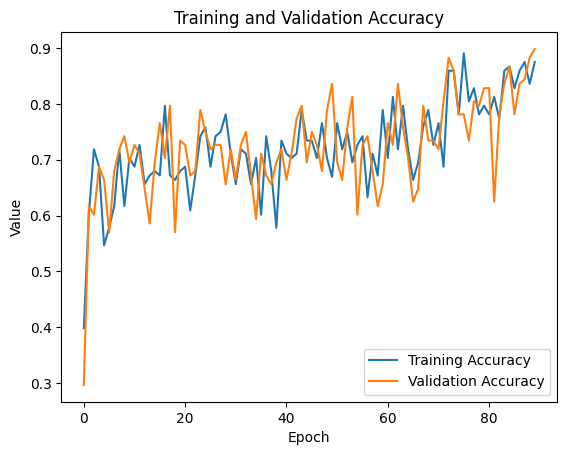

In [16]:
# Training and Validation Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

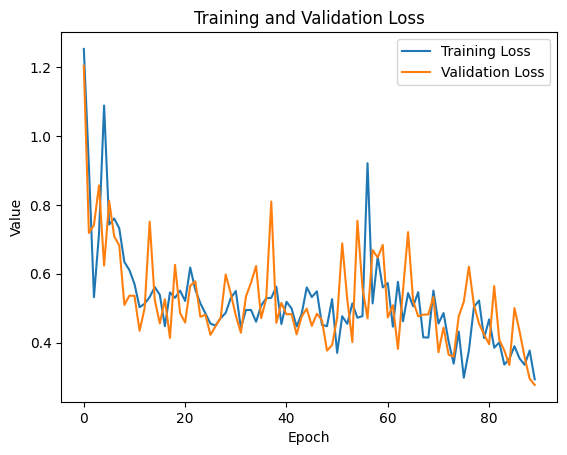

In [17]:
# Training and Validation Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [18]:
print(train_generator.class_indices)

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


## Menggunggah gambar untuk diprediksi

Saving desert(10).jpg to desert(10) (2).jpg
1/1 [==============================] - 0s 164ms/step
desert(10) (2).jpg
desert


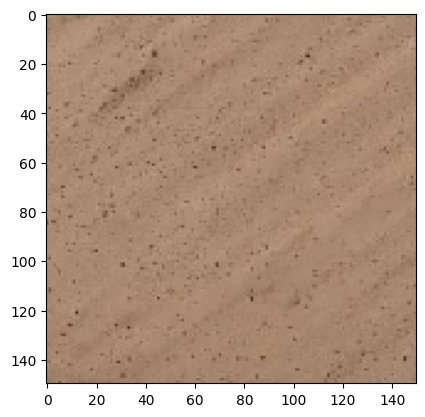

In [19]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('cloudy')
  elif classes[0,1]!=0:
    print('desert')
  elif classes[0,2]!=0:
    print('Green Area')
  elif classes[0,3]!=0:
    print('Water')
  else:
    print('Unknown')

## Menyimpan model dalam format TF-Lite

In [20]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [21]:
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('satelite.tflite')
tflite_model_file.write_bytes(tflite_model)

27258784